# CLUSTERING COUNTRIES BASED ON SOCIO-ECONOMIC AND HEALTH FACTORS FOR FINANCIAL AID BY NGO (K-MEANS & HIERARCHIAL CLUSTERING)

## Approach
Based on the business problem and looking at the dataset at a high level, below approach will be follwed to solve this problem.

- Check for missing value and treatment
- Check for outlier and treatment
- Perform the basic EDA to find the variablity and distribution of the data, so as to identify if we need to scale the data
- Data Scaling if necessary
- Use Hopkins Method to check if the dataset is good enough for a cluster analysis
- Using Hierarchical clustering to identify the optimal cluster value.
- Use Silhouette and Elbow method to validate the optimal cluster values.
- Use K-Means Cluster method to build the final cluster model.
- Analyse the cluster representing the countries that will solve the Business Problem.
- Present the final report

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read the dataset
ngo = pd.read_csv("Country-data.csv")
ngo.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# Shape of the dataframe (Rows & Columns)
ngo.shape

(167, 10)

In [5]:
# basic information of the dataframe
ngo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# Descriptive Statistics

ngo.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Observation:
Dataframe has data about various countries and their socio-economic factors. Few are in % and others in absolute values. - Dataframe has 10 Columns and 167 Rows - One variable is 'Object' Type, and rest all are 'Int' or 'Float' type - Descriptive Statistics tells us that there is variablity in the data, and will require scaling before model building.

## Missing value check

In [7]:
ngo.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### Observation: 
There seems to be NO MISSING values in the dataset

### Dropping duplicates (if any)

In [8]:
cols_with_zerodata_inpercent = round(100*(ngo.isnull().sum()/len(ngo.index)), 2)

print("Columns with 100% missing data:")
colnames = ngo.columns[cols_with_zerodata_inpercent==100].values
print("Num col:", len(colnames), colnames)

cols_with_nonuniq_values = ngo.nunique()
colnamesnouniq = ngo.columns[(cols_with_nonuniq_values <= 1)].values
print("Columns with just 1 unique value:", len(colnamesnouniq), colnamesnouniq)

ngo.drop_duplicates(keep=False, inplace=True)

ngo.shape

Columns with 100% missing data:
Num col: 0 []
Columns with just 1 unique value: 0 []


(167, 10)

### Observation: 
There seems to be NO DUPLICATE values in the dataset

## Data Transformation

In our dataframe (ngo), the 'imports', 'exports' and 'health' variable seems to be in percentage of GDP per capita, and this can sometimes give an incorrect insight in our EDA. For example, the health spending of 'United states' is 17.9 and that of 'Sierra Leone' is '13.1', both of which are very close to each other in their % of health spending but there is huge margin in terms of their GDP per capita. But these figures do not actually tell us the real story of how rich and poor are 'USA' and 'Sierra Leone' is. So the best way to tackle it is to convert the % values to ABSOLUTE values.

In [9]:
#Checking the values before transformation
ngo.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [10]:
# Converting imports, exports and health spending from percentage to absolute values.

# As imports, exports and health are given as %age of the GDP per capita. Let's perform these conversion.
ngo['imports'] = ngo['imports'] * ngo['gdpp']/100 
ngo['exports'] = ngo['exports'] * ngo['gdpp']/100
ngo['health'] = ngo['health'] * ngo['gdpp']/100

print(ngo.shape)   # new shape of the dataframe
ngo.head()         # Transformed dataframe

(167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## Outlier Treatment

### Checking the Outlier values

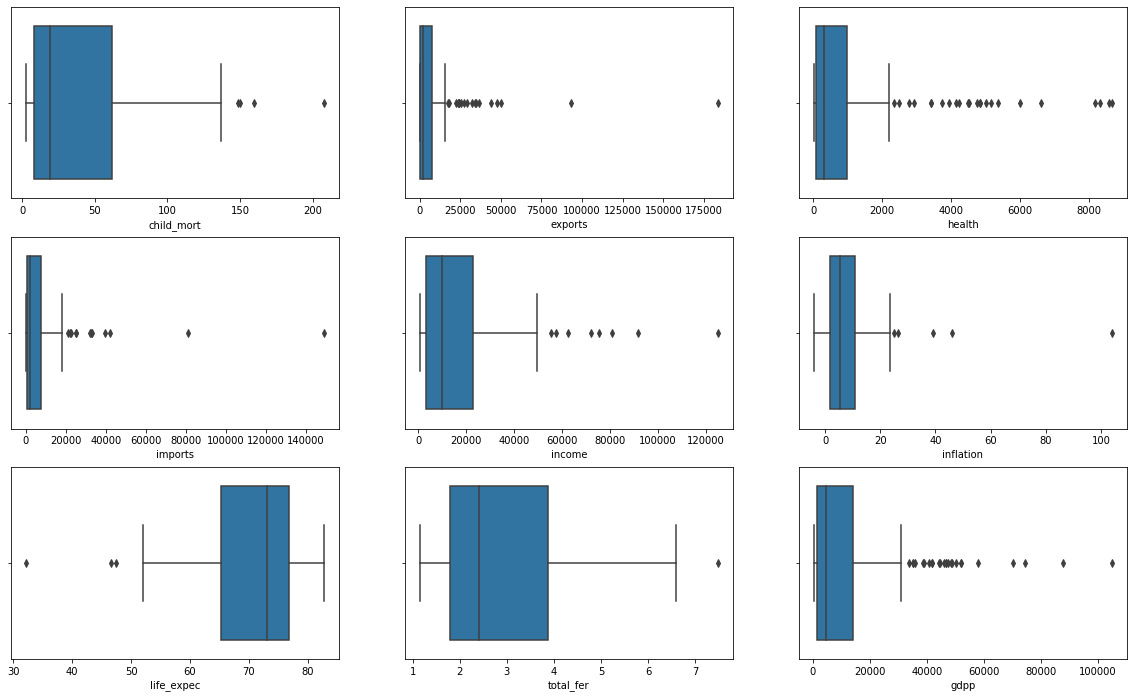

In [11]:
plt.figure(figsize=(20, 12))
ngo_num=ngo[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
for i in enumerate(ngo_num):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(ngo_num[i[1]])

### Observation: 
There seemes to be outliers in every single variable. This is a very delicate situation in terms of Business problem statement & Clustering analysis. 
- If we apply outlier treatment by CAPPING this will change the ranking of few countries with respect to requirement of Financial Aid. Also we will still have some outlier present after Capping, o we need to make a wise decision considering this.
- If we apply outlier treatment by Deletion based on IQR values, this will remove few countries from the list that would have really deserved the Financial Aid. 
- If we do not apply Outlier treatment, it can impact the clustering model, as the presence of Outlier can change the CENTROID (K-Means) of the cluster. 
- After considering all these scenarios, I've decided to treat the outliers by soft capping to 99th percentile for upper limit and 1 percentile for lower limit.

In [12]:
ngo_lower = ngo[['child_mort', 'inflation', 'total_fer']]
ngo_upper = ngo[['exports', 'health', 'imports', 'income',  'life_expec', 'gdpp']]
q1 = ngo['child_mort'].quantile(0.01)
q1 = ngo['inflation'].quantile(0.01)
q1 = ngo['total_fer'].quantile(0.01)

q2 = ngo['exports'].quantile(0.99)
q2 = ngo['health'].quantile(0.99)
q2 = ngo['imports'].quantile(0.99)
q2 = ngo['income'].quantile(0.99)
q2 = ngo['life_expec'].quantile(0.99)
q2 = ngo['gdpp'].quantile(0.99)

print(q1, q2)

1.2431999999999999 79088.00000000004


In [13]:
ngo['child_mort'][ngo['child_mort']<=q1] = q1
ngo['inflation'][ngo['inflation']<=q1] = q1
ngo['total_fer'][ngo['total_fer']<=q1] = q1

ngo['exports'][ngo['exports']>=q2] = q2
ngo['health'][ngo['health']>=q2] = q2
ngo['imports'][ngo['imports']>=q2] = q2
ngo['income'][ngo['income']>=q2] = q2
ngo['life_expec'][ngo['life_expec']>=q2] = q2
ngo['gdpp'][ngo['gdpp']>=q2] = q2

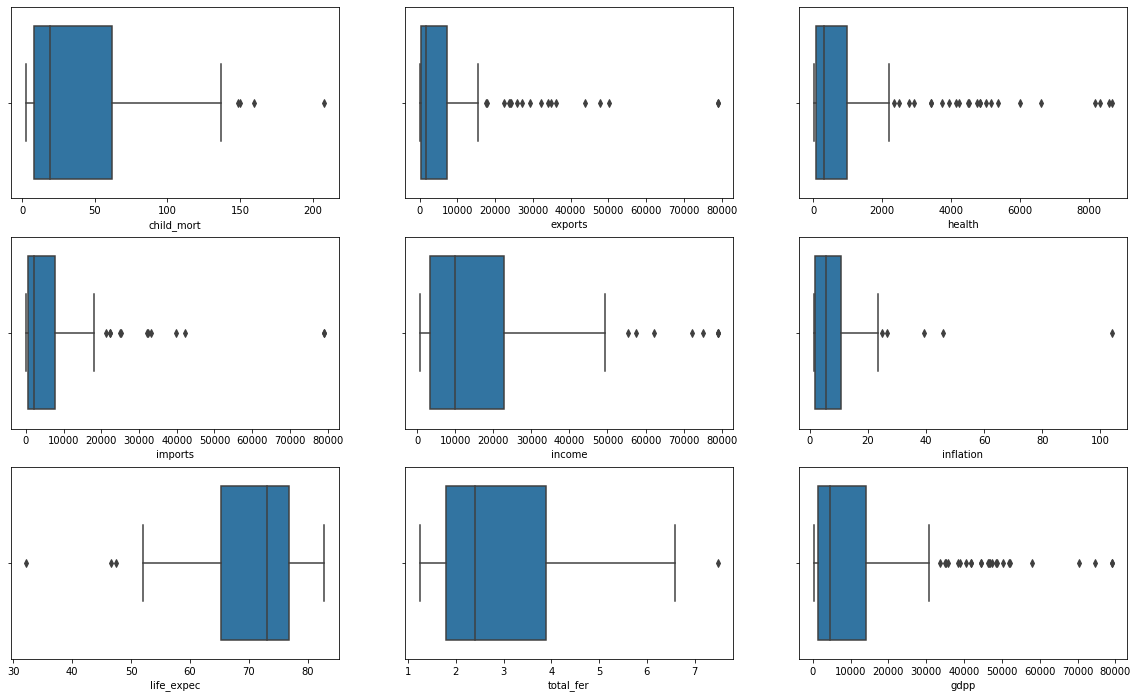

In [14]:
plt.figure(figsize=(20, 12))
ngo_num=ngo[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
for i in enumerate(ngo_num):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.boxplot(ngo_num[i[1]])

## Exploratory Data Analysis

## Visualising Distribution

#### Let's make a pairplot of all the numeric variables

In [15]:
ngo.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

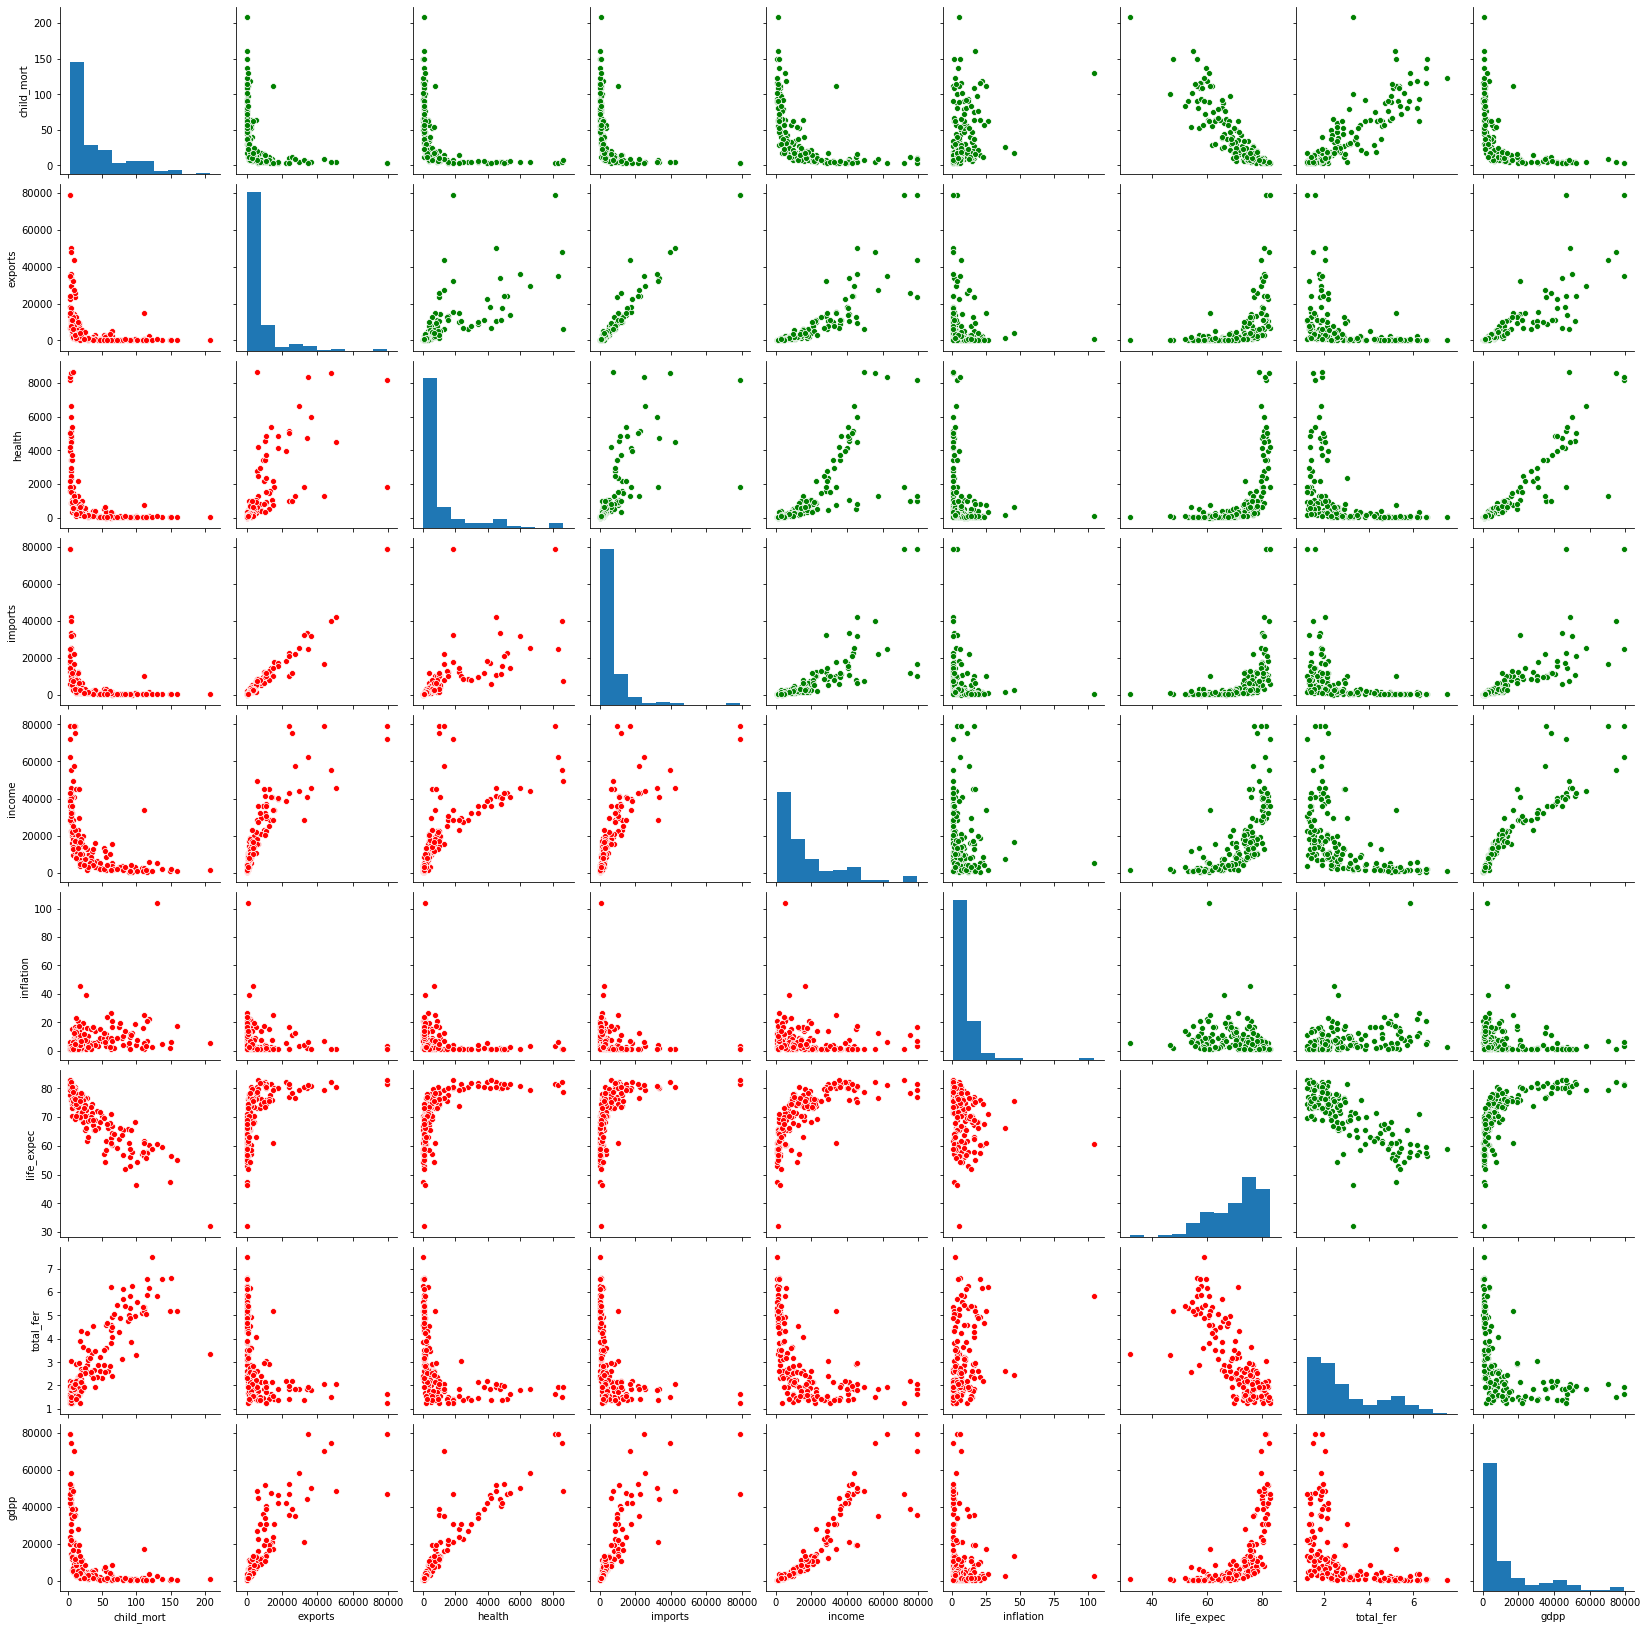

In [16]:
g = sns.PairGrid(ngo_num)
g.map_upper(sns.scatterplot,color='green')
g.map_lower(sns.scatterplot, color='red')
g.map_diag(plt.hist)

plt.show()

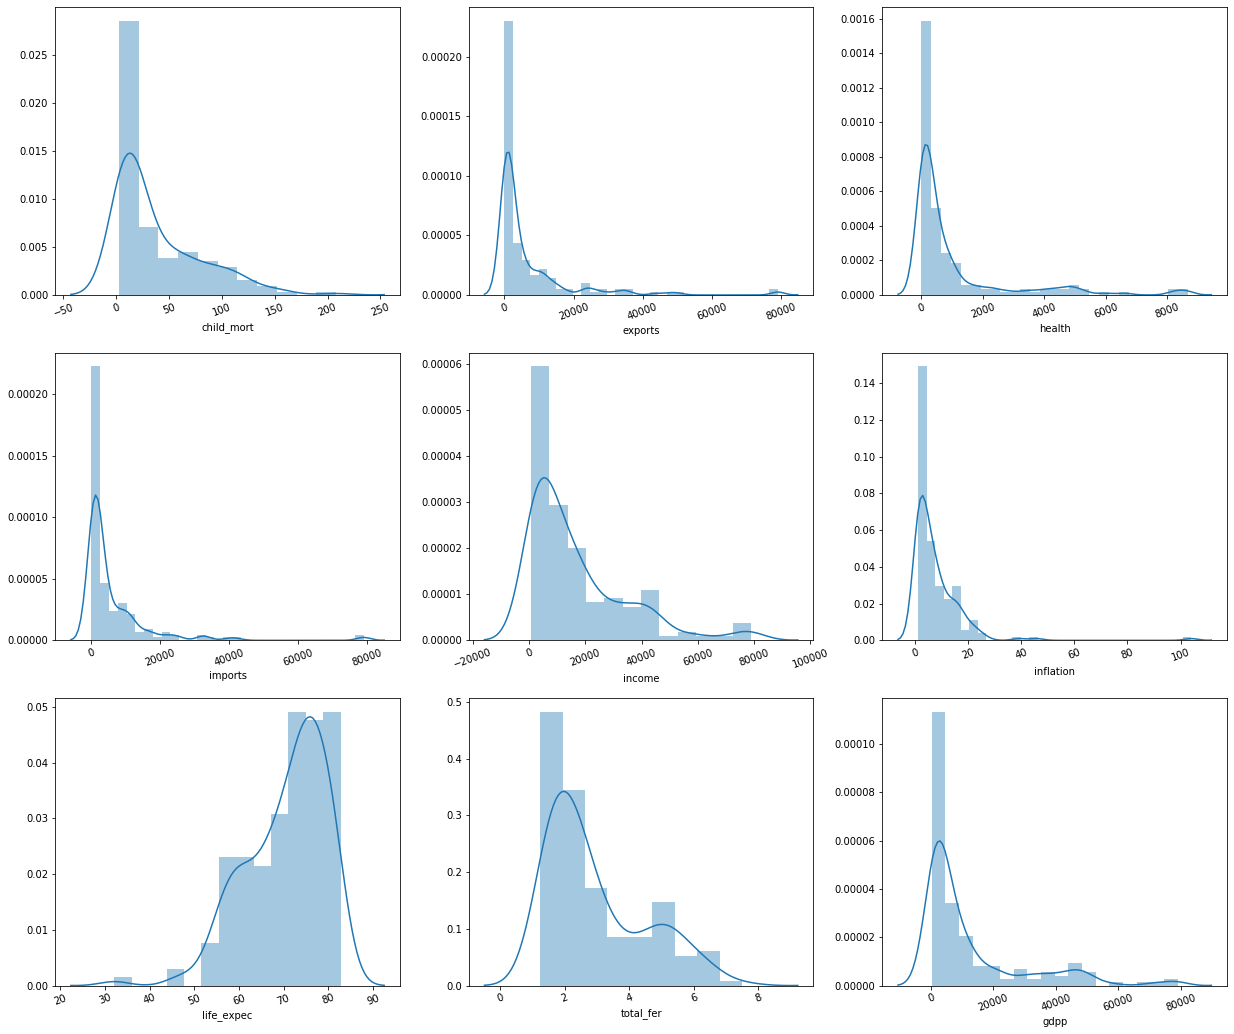

In [17]:
plt.figure(figsize=(21, 18))
for i in enumerate(ngo_num):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(ngo_num[i[1]])
    plt.xticks(rotation=20)

### Observation: 
Most of the data point are 'NOT Normally' distributed. 
- Their variance are also differernt. 
- Their range are also different 

All the above points indicates the need of standardising the data before we build the model. Since we need to compute the Euclidean distance between the data points, it is important to ensure that the attributes with a larger range of values do not out-weigh the attributes with smaller range. Thus, scaling down of all attributes to the same normal scale is important here.

## Scaling the data

- We will use Standardisation method for scaling the data.
- In clustering analyses, standardization may be especially crucial in order to compare similarities between features based on certain distance measures since we are interested in the components that maximize the variance.

In [18]:
ngo.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [19]:
# New dataframe with only Numeric variables, for scaling

ngo_new=ngo[['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']].copy()

In [20]:
# rescaling the numeric columns

# instantiate
scaler = StandardScaler()

# fit_transform
ngo_scaled = scaler.fit_transform(ngo_new)


print(ngo_scaled.shape)
print(ngo_scaled)

(167, 9)
[[ 1.29153238 -0.53991157 -0.56503989 ... -1.61909203  1.90339023
  -0.70225949]
 [-0.5389489  -0.45147739 -0.43921769 ...  0.64786643 -0.86081558
  -0.49872564]
 [-0.27283273 -0.40543547 -0.48482608 ...  0.67042323 -0.03884551
  -0.47743428]
 ...
 [-0.37231541 -0.46786762 -0.53848844 ...  0.28695762 -0.66195186
  -0.65869853]
 [ 0.44841668 -0.51251069 -0.55059641 ... -0.34463279  1.14107928
  -0.65869853]
 [ 1.11495062 -0.50056692 -0.54049845 ... -2.09278484  1.62498101
  -0.6500669 ]]


In [21]:
#Converting it into a dataframe

ngo_scaled = pd.DataFrame(ngo_scaled)
ngo_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']
ngo_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.539912,-0.565040,-0.532721,-0.860279,0.139346,-1.619092,1.903390,-0.702259
1,-0.538949,-0.451477,-0.439218,-0.375900,-0.388620,-0.337586,0.647866,-0.860816,-0.498726
2,-0.272833,-0.405435,-0.484826,-0.428848,-0.220251,0.781037,0.670423,-0.038846,-0.477434
3,2.007808,-0.365957,-0.532363,-0.418577,-0.617080,1.388041,-1.179234,2.128769,-0.530950
4,-0.695634,-0.093992,-0.178771,0.092738,0.131226,-0.631453,0.704258,-0.542634,-0.032042


## Hopkins Statistics

Before we apply any clustering algorithm to the given data, it's important to check whether the given data has some meaningful clusters or not? which in general means the given data is not random. The process to evaluate the data to check if the data is feasible for clustering or not is know as the clustering tendency. To check cluster tendency, we use Hopkins test. Hopkins test examines whether data points differ significantly from uniformly distributed data in the multidimensional space.

In [22]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [23]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(ngo_scaled)

0.9309653761546339

### Observation: 
Hopkins Statistic over .70 is a good score that indicated that the data is good for cluster analysis. - A 'Hopkins Statistic' value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

## Modelling

## Hierarchical Clustering

As mentioned in the 'Approach' section, we will use Hierarchical Clustering to identify appropriate cluster size with a good split of data (Max Intra-Cluster distance & Min Inter-Cluster Distance)

### Single Linkage

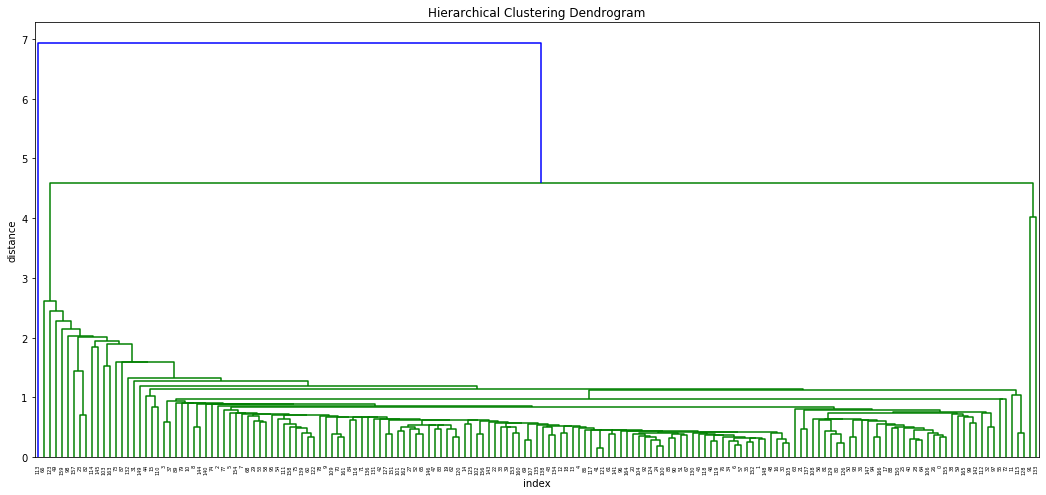

In [24]:
# single linkage: : Here, the distance between 2 clusters is defined as the shortest distance between points in the two clusters.

plt.figure(figsize=(18, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
mergings_s = linkage(ngo_scaled, method="single", metric='euclidean')
dendrogram(mergings_s)
plt.show()

### Complete Linkage

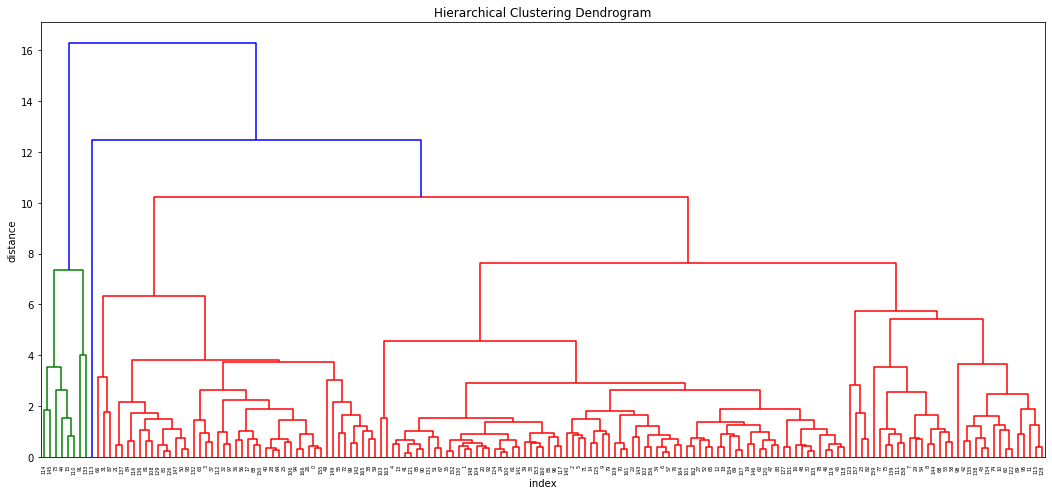

In [25]:
# complete linkage : Here, the distance between 2 clusters is defined as the maximum distance between any 2 points in the clusters.

plt.figure(figsize=(18, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
mergings_c = linkage(ngo_scaled, method="complete", metric='euclidean')
dendrogram(mergings_c)
plt.show()

### Observation: 
From the above Dendrograms, it is evident that 'Complete Linkage' give a better cluster formation as the heirarchy is clearly differentiable and the number of clusters formed is easy to interpret.
So we will use Complete linkage output for our further analysis. We will build two iterations of clustering with 3 & 4 clusters (based on inputs from the above Dendrogram with Complete Linkage) and analyse the output.

### First Iteration - Using 3 Clusters

In [26]:
# 3 clusters
cluster_labels_3 = cut_tree(mergings_c, n_clusters=3).reshape(-1, )
cluster_labels_3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
# Create a new datafame with cluster labels to it.
ngo_country_h = ngo.copy()
ngo_country_h['cluster_labels_3'] = cluster_labels_3

ngo_country_h.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


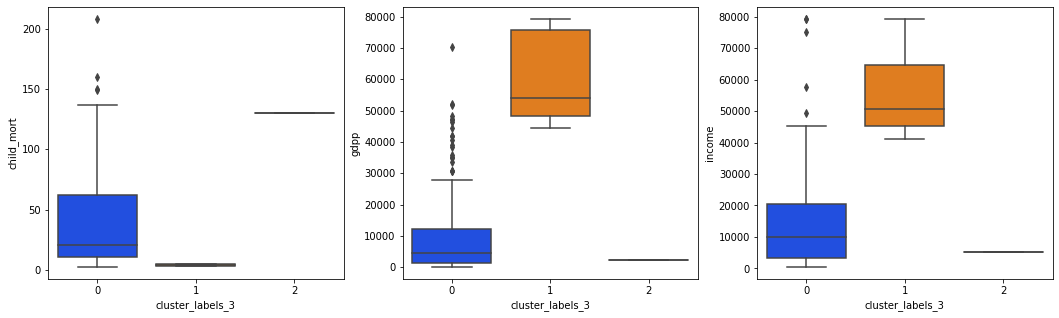

In [28]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_labels_3', y='child_mort', data=ngo_country_h, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_labels_3', y='gdpp', data=ngo_country_h, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_labels_3', y='income', data=ngo_country_h, palette="bright")

plt.show()

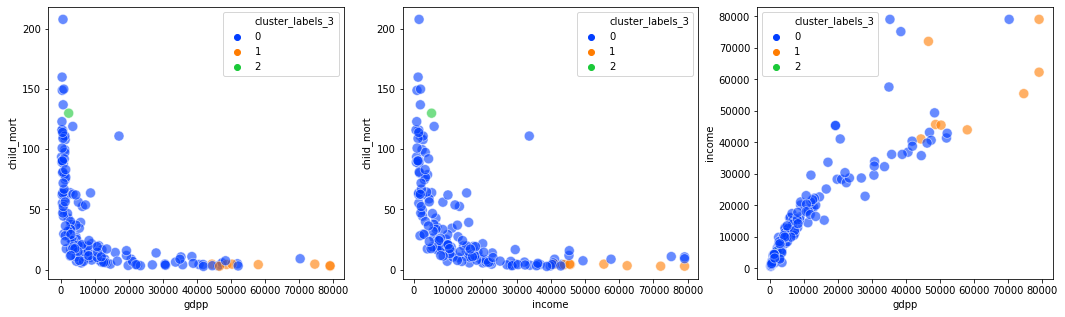

In [29]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_labels_3',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_labels_3',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_labels_3',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.show()

In [30]:
# Checking cluster count

ngo_country_h.cluster_labels_3.value_counts()

0    158
1      8
2      1
Name: cluster_labels_3, dtype: int64

In [31]:
# Checking the countries in Cluster 2 to see which are the countries in that segment.

ngo_country_h[ngo_country_h['cluster_labels_3'] ==2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3
113,Nigeria,130.0,589.49,118.131,405.42,5150.0,104.0,60.5,5.84,2330.0,2


In [32]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

ngo_country_h[ngo_country_h['cluster_labels_3'] == 1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3
15,Belgium,4.5,33921.6,4750.80,33166.8,41100.0,1.8800,80.0,1.8600,44400.0,1
44,Denmark,4.1,29290.0,6612.00,25288.0,44000.0,3.2200,79.5,1.8700,58000.0,1
73,Ireland,4.2,50161.0,4475.53,42125.5,45700.0,1.2432,80.4,2.0500,48700.0,1
91,Luxembourg,2.8,79088.0,8158.50,79088.0,79088.0,3.6200,81.3,1.6300,79088.0,1
110,Netherlands,4.5,36216.0,5985.70,31990.8,45500.0,1.2432,80.7,1.7900,50300.0,1
114,Norway,3.2,34856.6,8323.44,25023.0,62300.0,5.9500,81.0,1.9500,79088.0,1
133,Singapore,2.8,79088.0,1845.36,79088.0,72100.0,1.2432,82.7,1.2432,46600.0,1
145,Switzerland,4.5,47744.0,8579.00,39761.8,55500.0,1.2432,82.2,1.5200,74600.0,1


### Observation: 
Cluster 1 & 2 seems to be Developed or Developing countries, so our segmentation is good in terms of all our under developed countries are segmented under cluster 0. We will further fine tune this cluster.

### Second Iteration - Using 4 Clusters

In [33]:
# 4 clusters
cluster_labels_4 = cut_tree(mergings_c, n_clusters=4).reshape(-1, )
cluster_labels_4

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 1, 0, 3, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [34]:
ngo_country_h['cluster_labels_4'] = cluster_labels_4

ngo_country_h.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [35]:
ngo_country_h.shape

(167, 12)

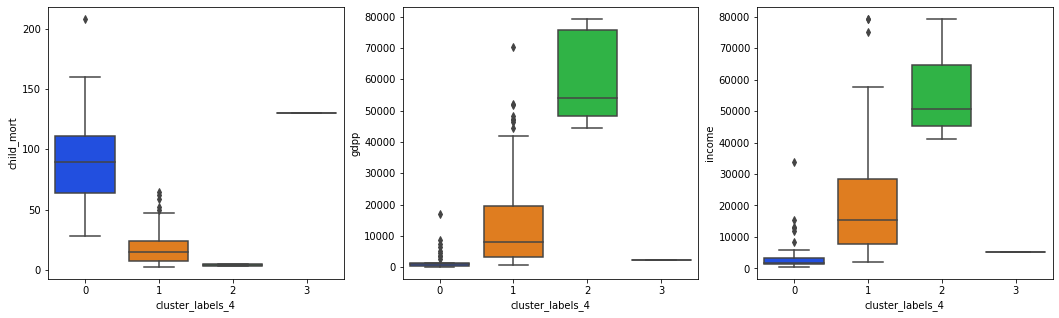

In [36]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_labels_4', y='child_mort', data=ngo_country_h, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_labels_4', y='gdpp', data=ngo_country_h, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_labels_4', y='income', data=ngo_country_h, palette="bright")

plt.show()

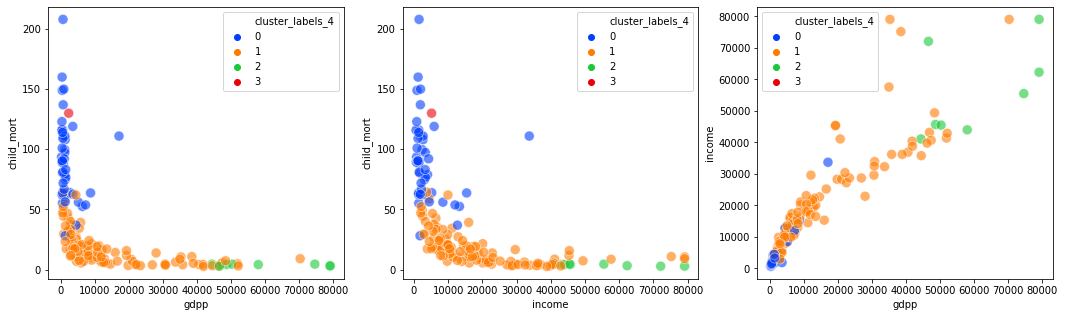

In [37]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_labels_4',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_labels_4',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_labels_4',
                data=ngo_country_h, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.show()

In [38]:
ngo_country_h.cluster_labels_4.value_counts()

1    111
0     47
2      8
3      1
Name: cluster_labels_4, dtype: int64

In [39]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

ngo_country_h[ngo_country_h['cluster_labels_4'] == 3]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
113,Nigeria,130.0,589.49,118.131,405.42,5150.0,104.0,60.5,5.84,2330.0,2,3


In [40]:
# Checking the countries in Cluster 2 to see which are the countries in that segment.

ngo_country_h[ngo_country_h['cluster_labels_4'] == 2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
15,Belgium,4.5,33921.6,4750.80,33166.8,41100.0,1.8800,80.0,1.8600,44400.0,1,2
44,Denmark,4.1,29290.0,6612.00,25288.0,44000.0,3.2200,79.5,1.8700,58000.0,1,2
73,Ireland,4.2,50161.0,4475.53,42125.5,45700.0,1.2432,80.4,2.0500,48700.0,1,2
91,Luxembourg,2.8,79088.0,8158.50,79088.0,79088.0,3.6200,81.3,1.6300,79088.0,1,2
110,Netherlands,4.5,36216.0,5985.70,31990.8,45500.0,1.2432,80.7,1.7900,50300.0,1,2
114,Norway,3.2,34856.6,8323.44,25023.0,62300.0,5.9500,81.0,1.9500,79088.0,1,2
133,Singapore,2.8,79088.0,1845.36,79088.0,72100.0,1.2432,82.7,1.2432,46600.0,1,2
145,Switzerland,4.5,47744.0,8579.00,39761.8,55500.0,1.2432,82.2,1.5200,74600.0,1,2


In [41]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

ngo_country_h[ngo_country_h['cluster_labels_4'] == 1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
1,Albania,16.6,1145.20,267.895,1987.74,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.982,1400.44,12900.0,16.10,76.5,2.89,4460.0,0,1
4,Antigua and Barbuda,10.3,5551.00,735.660,7185.80,19100.0,1.44,76.8,2.13,12200.0,0,1
5,Argentina,14.5,1946.70,834.300,1648.00,18700.0,20.90,75.8,2.37,10300.0,0,1
6,Armenia,18.1,669.76,141.680,1458.66,6700.0,7.77,73.3,1.69,3220.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
160,Uruguay,10.6,3129.70,993.650,3022.60,17100.0,4.91,76.4,2.08,11900.0,0,1
161,Uzbekistan,36.3,437.46,80.178,393.30,4240.0,16.50,68.8,2.34,1380.0,0,1
162,Vanuatu,29.2,1384.02,155.925,1565.19,2950.0,2.62,63.0,3.50,2970.0,0,1
163,Venezuela,17.1,3847.50,662.850,2376.00,16500.0,45.90,75.4,2.47,13500.0,0,1


### Observation:
From the above 2 iterations of Hierarchical Clustering, it is evident that 3 CLUSTERS is ideal number of clusters, because when we used 4 clusters, we could see that Nigeria was added as a seperate segment. Since Nigera could be a possible candidate for financial aid in terms of their child mortality rate, we will consider the ideal number of cluster to be 3. We will further validate with other methods below.

### Interpreting the Clusters from Hierarchical model

In [42]:
#New dataframe for group by & analysis
ngo_country_h_analysis =  ngo_country_h.groupby(['cluster_labels_3']).mean()
ngo_country_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_4
cluster_labels_3,,,,,,,,,,
0,39.433544,4617.181377,807.759393,4255.123304,14890.436709,7.666537,70.091772,2.991539,10425.848101,0.702532
1,3.825000,48795.650000,6091.291250,44441.487500,55661.000000,2.455350,80.975000,1.739150,60097.000000,2.000000
2,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,3.000000


In [43]:
# Creating a new field for count of observations in each cluster
ngo_country_h_analysis['Observations']=ngo_country_h[['cluster_labels_3','child_mort']].groupby(['cluster_labels_3']).count()
ngo_country_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_4,Observations
cluster_labels_3,,,,,,,,,,,
0,39.433544,4617.181377,807.759393,4255.123304,14890.436709,7.666537,70.091772,2.991539,10425.848101,0.702532,158
1,3.825000,48795.650000,6091.291250,44441.487500,55661.000000,2.455350,80.975000,1.739150,60097.000000,2.000000,8
2,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,3.000000,1


In [44]:
# Creating a new field for proportion of observations in each cluster
ngo_country_h_analysis['Proportion']=round(ngo_country_h_analysis['Observations']/ngo_country_h_analysis['Observations'].sum(),2)
ngo_country_h_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_4,Observations,Proportion
cluster_labels_3,,,,,,,,,,,,
0,39.433544,4617.181377,807.759393,4255.123304,14890.436709,7.666537,70.091772,2.991539,10425.848101,0.702532,158,0.95
1,3.825000,48795.650000,6091.291250,44441.487500,55661.000000,2.455350,80.975000,1.739150,60097.000000,2.000000,8,0.05
2,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,3.000000,1,0.01


<Figure size 576x360 with 0 Axes>

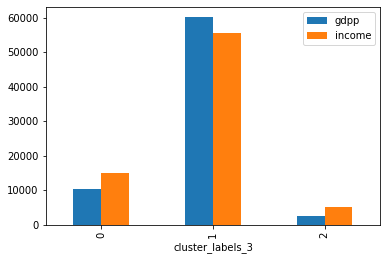

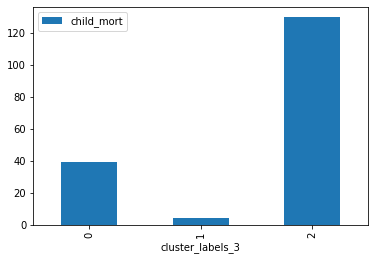

In [45]:
plt.figure(figsize=(8, 5))
ngo_country_h_plot1=ngo_country_h[['cluster_labels_3','gdpp','income']].copy()
ngo_country_h_plot1=ngo_country_h_plot1.groupby('cluster_labels_3').mean()
ngo_country_h_plot1.plot.bar()

ngo_country_h_plot2=ngo_country_h[['cluster_labels_3','child_mort']].copy()
ngo_country_h_plot2=ngo_country_h_plot2.groupby('cluster_labels_3').mean()
ngo_country_h_plot2.plot.bar()

### Observation:
Cluster 0 has the Highest average Child Mortality rate of ~42 when compared to other 3 clusters, and Lowest average GDPP & Income of ~ 7551 & 12641 respectively. All these figures clearly makes this cluster the best candidate for the financial aid from NGO. We could also see that Cluster 0 comprises of ~89% of overall data, and has ~148 observations in comparision to 167 total observations This seems to be a problem. This means that Hierarchical clustering is not giving us a good result as 89% of the data points are segmented into that cluster. We also saw that increasing the cluster number is not solving this problem. We will perform K-Means Clustering and check how that turns out to be. 

## Finding the Optimal Number of Clusters

### SSD (Elbow Curve)

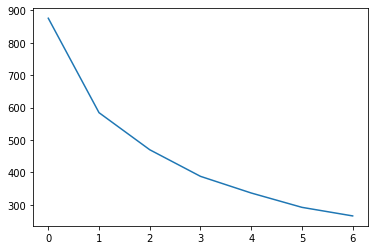

In [46]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(ngo_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [47]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(ngo_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(ngo_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4731447504258156
For n_clusters=3, the silhouette score is 0.4229101622658904
For n_clusters=4, the silhouette score is 0.4051014515704492
For n_clusters=5, the silhouette score is 0.4118733283250245
For n_clusters=6, the silhouette score is 0.3817548018304656
For n_clusters=7, the silhouette score is 0.2895442192440477
For n_clusters=8, the silhouette score is 0.2974354488362795


### Observation:
From the above validations(Elbow Curve & silhouette analysis), we could see that 3,4 or 5 clusters are optimal number of clusters to be used. We will try 3 different iterations in K-Means clustering using 3,4 and 5 Clusters and analyse the results.

## K-Means Clustering

### First Iteration - Using 3 Clusters

In [48]:
# K Means with with k=3
kmeans_3 = KMeans(n_clusters=3, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_3.fit(ngo_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=335, tol=0.0001, verbose=0)

In [49]:
kmeans_3.labels_

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])

In [50]:
# Create a new datafame with scaled data and adding country name to it.
ngo_country_k = ngo_country_h.copy()
ngo_country_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [51]:
# assign the label
ngo_country_k['cluster_id_3'] = kmeans_3.labels_
ngo_country_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1,2


In [52]:
# Checking the number of countries in each cluster

ngo_country_k.cluster_id_3.value_counts()

2    92
0    48
1    27
Name: cluster_id_3, dtype: int64

### Visualizing the Clustered Data

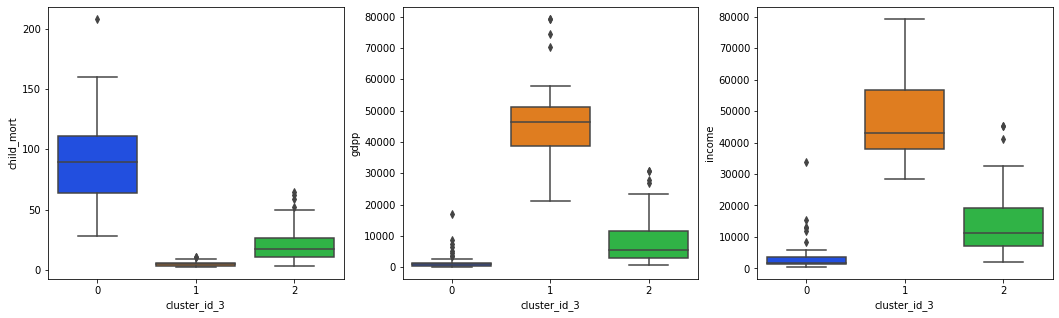

In [53]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_3', y='child_mort',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_3', y='gdpp',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_3', y='income',
            data=ngo_country_k, palette="bright")

plt.show()

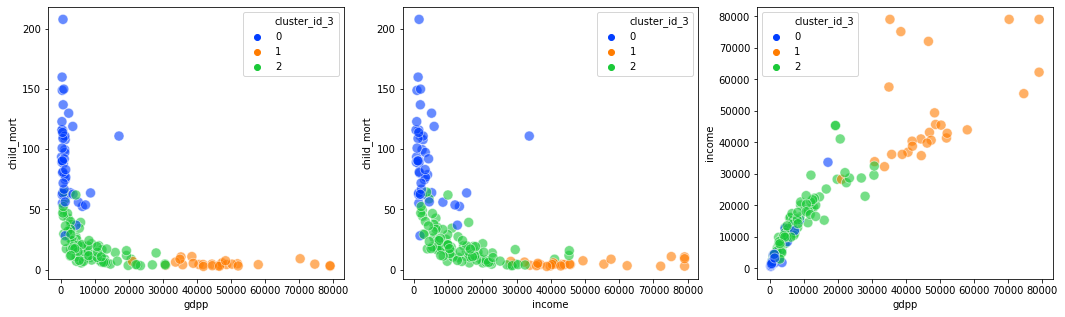

In [54]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_3',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_3',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_3',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.show()

In [55]:
# Checking the CLuster means:
ngo_country_k.groupby(['cluster_id_3']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4
cluster_id_3,,,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.919925,59.239583,4.992083,1909.208333,0.041667,0.062500
2,20.177174,3650.066288,573.165330,3759.545881,14169.456522,7.229430,73.552174,2.225796,8226.869565,0.000000,1.000000
1,5.092593,27498.822222,4378.955185,23802.637037,48609.777778,3.618207,80.462963,1.778637,47476.888889,0.296296,1.296296


### Observation:
Cluster 2 & Cluster 0 seems to have highest Child Mortality and lowest Income & GDPP. Lets check the countries in these clusters to see there outcome.

In [56]:
# Checking the countries in Cluster 2 to see which are the countries in that segment.

ngo_country_k[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_3'] == 2].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
107,Myanmar,64.4,3720.0,988.0
154,Turkmenistan,62.0,9940.0,4440.0
69,India,58.8,4410.0,1350.0
146,Tajikistan,52.4,2110.0,738.0
12,Bangladesh,49.4,2440.0,758.0
...,...,...,...,...
122,Portugal,3.9,27200.0,22500.0
60,Greece,3.9,28700.0,26900.0
139,Spain,3.8,32500.0,30700.0
43,Czech Republic,3.4,28300.0,19800.0


In [57]:
# Checking the countries in Cluster 0 to see which are the countries in that segment.

ngo_country_h[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_3'] == 0].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
66,Haiti,208.0,1500.0,662.0
132,Sierra Leone,160.0,1220.0,399.0
32,Chad,150.0,1930.0,897.0
31,Central African Republic,149.0,888.0,446.0
97,Mali,137.0,1870.0,708.0
113,Nigeria,130.0,5150.0,2330.0
112,Niger,123.0,814.0,348.0
3,Angola,119.0,5900.0,3530.0
37,"Congo, Dem. Rep.",116.0,609.0,334.0
25,Burkina Faso,116.0,1430.0,575.0


### Second Iteration - Using 4 Clusters

In [58]:
# K Means with with k=4
kmeans_4 = KMeans(n_clusters=4, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_4.fit(ngo_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=335, tol=0.0001, verbose=0)

In [59]:
kmeans_4.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       3, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 3, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       3, 0, 1, 1, 3, 0, 1, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 3, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 3, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [60]:
# assign the label
ngo_country_k['cluster_id_4'] = kmeans_4.labels_
ngo_country_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_3,cluster_id_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0,0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1,2,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1,2,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0,0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1,2,2


In [61]:
# Checking the number of countries in each cluster

ngo_country_k.cluster_id_4.value_counts()

2    80
1    48
0    30
3     9
Name: cluster_id_4, dtype: int64

### Visualizing the Clustered Data

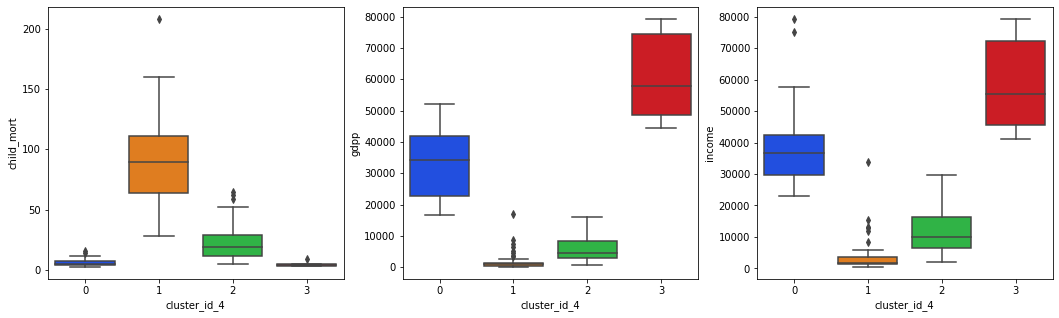

In [62]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_4', y='child_mort',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_4', y='gdpp',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_4', y='income',
            data=ngo_country_k, palette="bright")

plt.show()

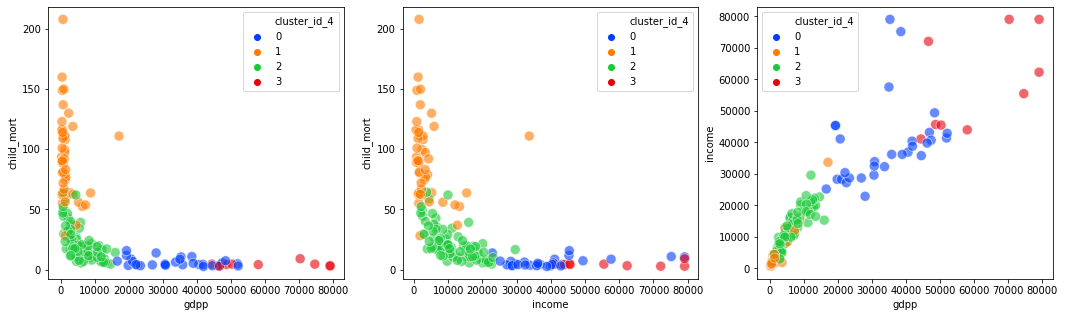

In [63]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_4',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_4',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_4',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.6)
plt.show()

In [64]:
# Checking the CLuster means:
ngo_country_k.groupby(['cluster_id_4']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_3
cluster_id_4,,,,,,,,,,,,
1,91.610417,879.063521,114.821765,827.028771,3897.354167,11.919925,59.239583,4.992083,1909.208333,0.041667,0.062500,0.0
2,22.157500,2580.729982,385.856630,2793.990264,11478.625000,7.640440,72.871250,2.273375,5962.150000,0.000000,1.000000,2.0
0,6.053333,14588.460000,3003.057000,13092.230000,39112.933333,4.164707,79.410000,1.831440,33690.000000,0.000000,1.000000,1.4
3,4.400000,48240.233333,5555.862222,41362.588889,58264.000000,2.958089,80.811111,1.775911,61230.666667,0.888889,1.888889,1.0


### Observation:
Cluster 3 & Cluster 1 seems to have highest Child Mortality and lowest Income & GDPP. Lets check the countries in these clusters to see their outcome.

In [65]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

ngo_country_k[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_4'] == 3].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
123,Qatar,9.0,79088.0,70300.0
15,Belgium,4.5,41100.0,44400.0
110,Netherlands,4.5,45500.0,50300.0
145,Switzerland,4.5,55500.0,74600.0
73,Ireland,4.2,45700.0,48700.0
44,Denmark,4.1,44000.0,58000.0
114,Norway,3.2,62300.0,79088.0
133,Singapore,2.8,72100.0,46600.0
91,Luxembourg,2.8,79088.0,79088.0


In [66]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

ngo_country_k[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_4'] == 1].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
66,Haiti,208.0,1500.0,662.0
132,Sierra Leone,160.0,1220.0,399.0
32,Chad,150.0,1930.0,897.0
31,Central African Republic,149.0,888.0,446.0
97,Mali,137.0,1870.0,708.0
113,Nigeria,130.0,5150.0,2330.0
112,Niger,123.0,814.0,348.0
3,Angola,119.0,5900.0,3530.0
37,"Congo, Dem. Rep.",116.0,609.0,334.0
25,Burkina Faso,116.0,1430.0,575.0


### Third Iteration - Using 5 Clusters

In [67]:
# K Means with with k=4
kmeans_5 = KMeans(n_clusters=5, max_iter=500, init='k-means++', n_init=10, random_state= 335)
kmeans_5.fit(ngo_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=335, tol=0.0001, verbose=0)

In [68]:
kmeans_5.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       3, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 3, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       3, 0, 1, 4, 3, 0, 1, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 3, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 3, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [69]:
# assign the label
ngo_country_k['cluster_id_5'] = kmeans_5.labels_
ngo_country_k.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_3,cluster_id_4,cluster_id_5
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0,0,1,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1,2,2,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1,2,2,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0,0,1,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1,2,2,2


In [70]:
# Checking the number of countries in each cluster

ngo_country_k.cluster_id_5.value_counts()

2    80
1    47
0    30
3     9
4     1
Name: cluster_id_5, dtype: int64

#### Visualizing the Clustered Data

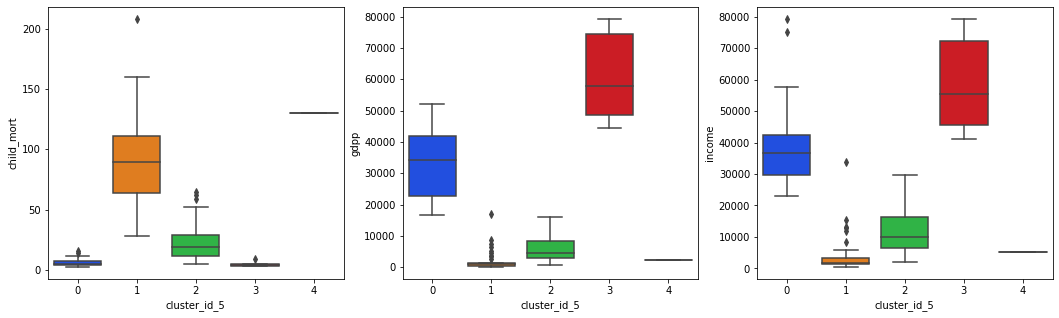

In [71]:
# Box plot on various variable against the CLUSTER_ID to visualize the spread of the data

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster_id_5', y='child_mort',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster_id_5', y='gdpp',
            data=ngo_country_k, palette="bright")
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster_id_5', y='income',
            data=ngo_country_k, palette="bright")

plt.show()

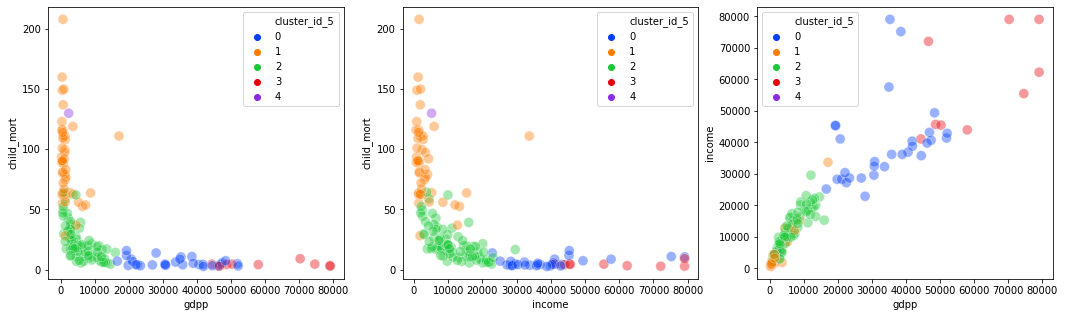

In [72]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='cluster_id_5',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 2)
sns.scatterplot(x='income', y='child_mort', hue='cluster_id_5',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.subplot(1, 3, 3)
sns.scatterplot(x='gdpp', y='income', hue='cluster_id_5',
                data=ngo_country_k, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
plt.show()

In [73]:
# Checking the CLuster means:
ngo_country_k.groupby(['cluster_id_5']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_3,cluster_id_4
cluster_id_5,,,,,,,,,,,,,
4,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,2.000000,3.000000,0.0,1.0
1,90.793617,885.224660,114.751355,835.999170,3870.702128,9.960774,59.212766,4.974043,1900.255319,0.000000,0.000000,0.0,1.0
2,22.157500,2580.729982,385.856630,2793.990264,11478.625000,7.640440,72.871250,2.273375,5962.150000,0.000000,1.000000,2.0,2.0
0,6.053333,14588.460000,3003.057000,13092.230000,39112.933333,4.164707,79.410000,1.831440,33690.000000,0.000000,1.000000,1.4,0.0
3,4.400000,48240.233333,5555.862222,41362.588889,58264.000000,2.958089,80.811111,1.775911,61230.666667,0.888889,1.888889,1.0,3.0


### Observation:
Cluster 3 & Cluster 1 seems to have highest Child Mortality and lowest Income & GDPP. Lets check the countries in these clusters to see their outcome.

In [74]:
# Checking the countries in Cluster 3 to see which are the countries in that segment.

ngo_country_k[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_5'] == 4].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
113,Nigeria,130.0,5150.0,2330.0


In [75]:
# Checking the countries in Cluster 1 to see which are the countries in that segment.

ngo_country_k[['country','child_mort','income','gdpp']][ngo_country_k['cluster_id_5'] == 0].sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])

,country,child_mort,income,gdpp
128,Saudi Arabia,15.7,45400.0,19300.0
10,Bahamas,13.8,22900.0,28000.0
115,Oman,11.7,45300.0,19300.0
82,Kuwait,10.8,75200.0,38500.0
23,Brunei,10.5,79088.0,35300.0
11,Bahrain,8.6,41100.0,20700.0
157,United Arab Emirates,8.6,57600.0,35000.0
159,United States,7.3,49400.0,48400.0
134,Slovak Republic,7.0,25200.0,16600.0
98,Malta,6.8,28300.0,21100.0


### Choosing the model

From the above 3 Iterations of K-Means, we could see that using 3 Clusters provided a better output in terms of a balanced cluster size. So we will consider the **'K-Means with 3 Clusters'** as our FINAL MODEL

## Interpreting the Clusters from K-Means model

In [76]:
#New dataframe for group by & analysis

ngo_country_k_analysis =  ngo_country_k.groupby(['cluster_id_3']).mean().sort_values(['child_mort','income','gdpp'],ascending = [False,True,True])
ngo_country_k_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_4,cluster_id_5
cluster_id_3,,,,,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.919925,59.239583,4.992083,1909.208333,0.041667,0.062500,1.00000,1.06250
2,20.177174,3650.066288,573.165330,3759.545881,14169.456522,7.229430,73.552174,2.225796,8226.869565,0.000000,1.000000,1.73913,1.73913
1,5.092593,27498.822222,4378.955185,23802.637037,48609.777778,3.618207,80.462963,1.778637,47476.888889,0.296296,1.296296,1.00000,1.00000


In [77]:
# Creating a new field for count of observations in each cluster

ngo_country_k_analysis['Observations']=ngo_country_k[['cluster_id_3','child_mort']].groupby(['cluster_id_3']).count()
ngo_country_k_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels_3,cluster_labels_4,cluster_id_4,cluster_id_5,Observations
cluster_id_3,,,,,,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.919925,59.239583,4.992083,1909.208333,0.041667,0.062500,1.00000,1.06250,48
2,20.177174,3650.066288,573.165330,3759.545881,14169.456522,7.229430,73.552174,2.225796,8226.869565,0.000000,1.000000,1.73913,1.73913,92
1,5.092593,27498.822222,4378.955185,23802.637037,48609.777778,3.618207,80.462963,1.778637,47476.888889,0.296296,1.296296,1.00000,1.00000,27


In [78]:
# Creating a new field for proportion of observations in each cluster

ngo_country_k_analysis['Proportion']=round(ngo_country_k_analysis['Observations']/ngo_country_k_analysis['Observations'].sum(),2)


#Summary View
ngo_country_k_analysis[['child_mort','income','gdpp','Observations','Proportion']]

,child_mort,income,gdpp,Observations,Proportion
cluster_id_3,,,,,
0,91.610417,3897.354167,1909.208333,48,0.29
2,20.177174,14169.456522,8226.869565,92,0.55
1,5.092593,48609.777778,47476.888889,27,0.16


<Figure size 576x360 with 0 Axes>

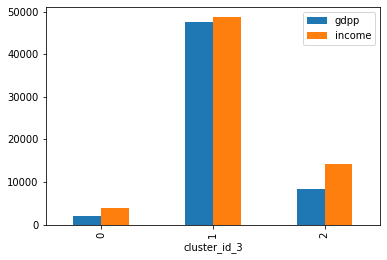

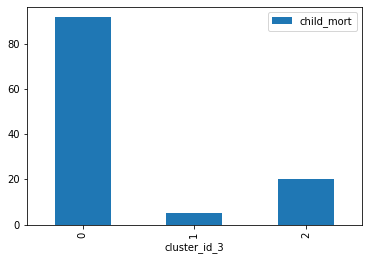

In [79]:
plt.figure(figsize=(8, 5))
ngo_country_k_plot1=ngo_country_k[['cluster_id_3','gdpp','income']].copy()
ngo_country_k_plot1=ngo_country_k_plot1.groupby('cluster_id_3').mean()
ngo_country_k_plot1.plot.bar()

ngo_country_k_plot2=ngo_country_k[['cluster_id_3','child_mort']].copy()
ngo_country_k_plot2=ngo_country_k_plot2.groupby('cluster_id_3').mean()
ngo_country_k_plot2.plot.bar()

### Interpretation of Clusters:
Cluster 2 has the Highest average Child Mortality rate of ~92 when compared to other 3 clusters, and Lowest average GDPP & Income of ~ 1909 & 3897 respectively. All these figures clearly makes this cluster the best candidate for the financial aid from NGO. We could also see that Cluster 2 comprises of ~29% of overall data, and has ~48 observations in comparision to 167 total observations

### Renaming the Clusters

In [80]:
ngo_country_k_analysis = ngo_country_k_analysis.rename({
    2: 'Under_Developed Countries',
    1: 'Developed Countries',
    0: 'Developing Countries'}).reset_index()

In [81]:
ngo_country_k_analysis[['cluster_id_3','child_mort','income','gdpp','Observations','Proportion']]

,cluster_id_3,child_mort,income,gdpp,Observations,Proportion
0,Developing Countries,91.610417,3897.354167,1909.208333,48,0.29
1,Under_Developed Countries,20.177174,14169.456522,8226.869565,92,0.55
2,Developed Countries,5.092593,48609.777778,47476.888889,27,0.16


### Final Cluster: 
Based on the above interpretation of the cluster, we now rename all the clusters accordingly. The Cluster 2 now becomes 'Under Developed Countries', which will be of our interest. --- We will further analyse the Cluster 'Under Developed Countries' and get to know various metrics of that data set, based on which we could identify our final set of countries which needs the financial support from the NGO

## Analysing the 'Under Developed Countries' Cluster

In [82]:
ngo_country_k.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'cluster_labels_3',
       'cluster_labels_4', 'cluster_id_3', 'cluster_id_4', 'cluster_id_5'],
      dtype='object')

In [83]:
# Countries in Cluster_id = 0,copy to a new dataframe, this will form our final cluster data

final_cluster = ngo_country_k[ngo_country_k['cluster_id_3'] == 2].copy()
final_cluster = final_cluster[['country', 'child_mort', 'income', 'gdpp']]

In [84]:
final_cluster.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

,country,child_mort,income,gdpp
109,Nepal,47.0,1990.0,592.0
146,Tajikistan,52.4,2110.0,738.0
12,Bangladesh,49.4,2440.0,758.0
27,Cambodia,44.4,2520.0,786.0
83,Kyrgyz Republic,29.6,2790.0,880.0
...,...,...,...,...
135,Slovenia,3.2,28700.0,23400.0
60,Greece,3.9,28700.0,26900.0
10,Bahamas,13.8,22900.0,28000.0
74,Israel,4.6,29600.0,30600.0


## Decision Making on the final approach

In [85]:
final_cluster.describe()

,child_mort,income,gdpp
count,92.000000,92.000000,92.000000
mean,20.177174,14169.456522,8226.869565
std,14.095983,9474.287745,7140.250011
min,3.200000,1990.000000,592.000000
25%,10.275000,7150.000000,3027.500000
50%,17.150000,11300.000000,5645.000000
75%,26.200000,19175.000000,11450.000000
max,64.400000,45400.000000,30700.000000


### Observation: 
Looking at the descriptive statistics of our Under Developed Countries cluster, we could notice that some of the countries have really high income and gdpp values (looking at the max values of income & gdpp). From a business problem prespective, we would want our numbers of child mortality, income and gdpp somewhere around the MEDIAN level (We decided to go with MEDIAN and not MEAN, as there seems to be a greater variablity in the income and gdpp values). So the approach we are going to take is to filter out all countries from our original list with income & gdpp less than the Median of 1860 & 932 respectively and Child Mortality >= the Median of 90. --- We will perform the filtering in the order GDPP --> INCOME --> CHILD MORTALITY --- This is due to reason that, we need to identify the countries with lowest GDPP & INCOME first and then with maximum CHILD MORTALITY. This is based on the understanding that, countries with highest child mortality and having higher gdpp & income will not have any impact on the child mortality rate even after the financial aid.

## Fetching the final data based on Cluster Median

### Data less than median of gdpp of the cluster

#### NOTE: We could see that the Median values of gdpp for 'Under Developed Countries' is ~932. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with gdpp <= 932.

In [86]:
Under_Developed_Countries = ngo[ngo['gdpp'] <= 932].copy()
Under_Developed_Countries=Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [87]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]


,country,child_mort,gdpp,income
26,Burundi,93.6,231.0,764.0
88,Liberia,89.3,327.0,700.0
37,"Congo, Dem. Rep.",116.0,334.0,609.0
112,Niger,123.0,348.0,814.0
132,Sierra Leone,160.0,399.0,1220.0
93,Madagascar,62.2,413.0,1390.0
106,Mozambique,101.0,419.0,918.0
31,Central African Republic,149.0,446.0,888.0
94,Malawi,90.5,459.0,1030.0
50,Eritrea,55.2,482.0,1420.0


In [88]:
Under_Developed_Countries.shape

(29, 10)

### Data less than median of income of the cluster

#### NOTE: We could see that the Median values of income for 'Under Developed Countries' is ~932. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with income <= 1860.

In [89]:
Under_Developed_Countries = Under_Developed_Countries[Under_Developed_Countries['income'] <= 1860]
Under_Developed_Countries=Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [90]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]

,country,child_mort,gdpp,income
26,Burundi,93.6,231.0,764.0
88,Liberia,89.3,327.0,700.0
37,"Congo, Dem. Rep.",116.0,334.0,609.0
112,Niger,123.0,348.0,814.0
132,Sierra Leone,160.0,399.0,1220.0
93,Madagascar,62.2,413.0,1390.0
106,Mozambique,101.0,419.0,918.0
31,Central African Republic,149.0,446.0,888.0
94,Malawi,90.5,459.0,1030.0
50,Eritrea,55.2,482.0,1420.0


In [91]:
Under_Developed_Countries.shape

(21, 10)

### Data greater than median of child mortality rate of the final cluster

#### NOTE: We could see that the Median values of Child Mortality for 'Under Developed Countries' is ~90. We will take this as a benchmark and fetch all countries from our 'ORIGINAL dataframe with Child Mortality >= 90.

In [92]:
# We create a new dataframe to store the countries satisfying the cluster median from original dataframe

Under_Developed_Countries = Under_Developed_Countries[Under_Developed_Countries['child_mort'] >= 90]
Under_Developed_Countries = Under_Developed_Countries.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False])

In [93]:
Under_Developed_Countries[['country', 'child_mort', 'gdpp', 'income']]

,country,child_mort,gdpp,income
26,Burundi,93.6,231.0,764.0
37,"Congo, Dem. Rep.",116.0,334.0,609.0
112,Niger,123.0,348.0,814.0
132,Sierra Leone,160.0,399.0,1220.0
106,Mozambique,101.0,419.0,918.0
31,Central African Republic,149.0,446.0,888.0
94,Malawi,90.5,459.0,1030.0
150,Togo,90.3,488.0,1210.0
64,Guinea-Bissau,114.0,547.0,1390.0
0,Afghanistan,90.2,553.0,1610.0


In [94]:
Under_Developed_Countries.shape

(14, 10)

### Descriptive Statistics of Cluster 'Under_Developed_Countries'

In [95]:
# Save the top 10 underdeveloped list to a new df

UDC_top_10 = Under_Developed_Countries[['country', 'gdpp', 'income', 'child_mort']].head(10).copy()

In [96]:
#Final country list

UDC_top_10

,country,gdpp,income,child_mort
26,Burundi,231.0,764.0,93.6
37,"Congo, Dem. Rep.",334.0,609.0,116.0
112,Niger,348.0,814.0,123.0
132,Sierra Leone,399.0,1220.0,160.0
106,Mozambique,419.0,918.0,101.0
31,Central African Republic,446.0,888.0,149.0
94,Malawi,459.0,1030.0,90.5
150,Togo,488.0,1210.0,90.3
64,Guinea-Bissau,547.0,1390.0,114.0
0,Afghanistan,553.0,1610.0,90.2


In [97]:
UDC_top_10.describe()

,gdpp,income,child_mort
count,10.00000,10.000000,10.00000
mean,422.40000,1045.300000,112.76000
std,99.62396,309.034356,25.11344
min,231.00000,609.000000,90.20000
25%,360.75000,832.500000,91.27500
50%,432.50000,974.000000,107.50000
75%,480.75000,1217.500000,121.25000
max,553.00000,1610.000000,160.00000


## Univariate Analysis of Cluster 'Under_Developed_Countries' (recommended 10)

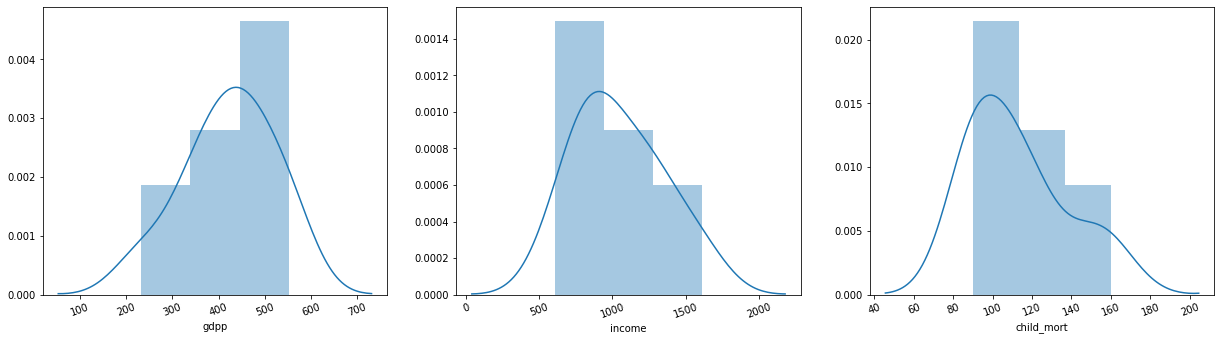

In [98]:
plt.figure(figsize=(21, 18))
features = ['gdpp','income','child_mort']
for i in enumerate(features):
    ax = plt.subplot(3, 3, i[0]+1)
    sns.distplot(UDC_top_10[i[1]])
    plt.xticks(rotation=20)

## Bivariate Analysis of Cluster 'Under_Developed_Countries' (recommended 10)

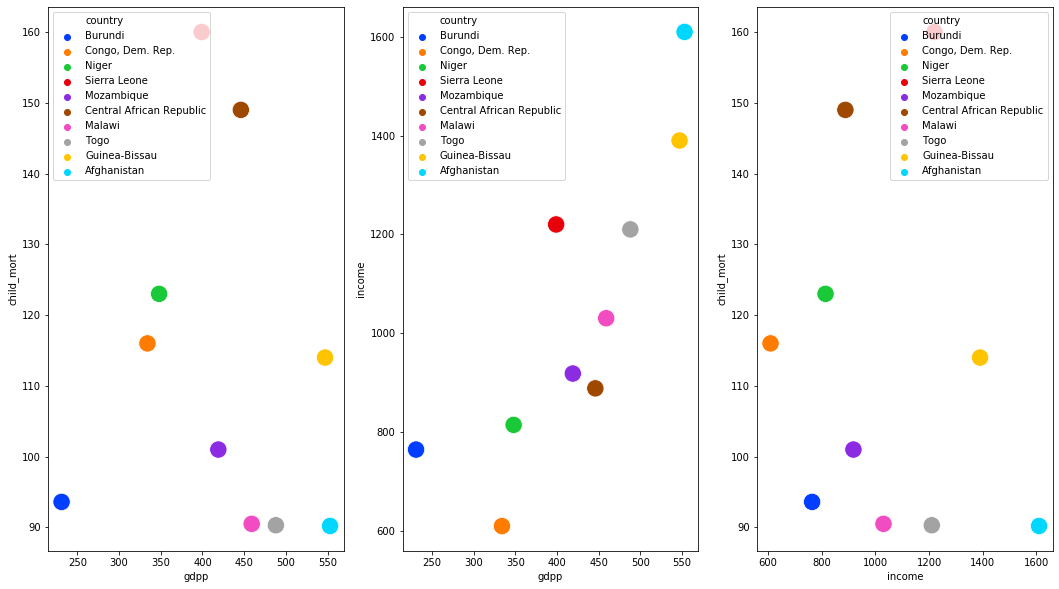

In [99]:
# Scatter plot on various variables to visualize the clusters based on them

plt.figure(figsize=(18, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(x='gdpp', y='child_mort', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.subplot(1, 3, 2)
sns.scatterplot(x='gdpp', y='income', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.subplot(1, 3, 3)
sns.scatterplot(x='income', y='child_mort', hue='country',
                data=UDC_top_10, legend='full', palette="bright", s=300, c='lightblue')
plt.show()

In [100]:
#TOP COUNTRIES recommended for Financial Aid

UDC_top_10

,country,gdpp,income,child_mort
26,Burundi,231.0,764.0,93.6
37,"Congo, Dem. Rep.",334.0,609.0,116.0
112,Niger,348.0,814.0,123.0
132,Sierra Leone,399.0,1220.0,160.0
106,Mozambique,419.0,918.0,101.0
31,Central African Republic,446.0,888.0,149.0
94,Malawi,459.0,1030.0,90.5
150,Togo,488.0,1210.0,90.3
64,Guinea-Bissau,547.0,1390.0,114.0
0,Afghanistan,553.0,1610.0,90.2


## Conclusion:
We performed CLUSTERING on the socio-economic data provided for various countries to identify countries to recommend for Financial Aid from the NGO. Based on our Clustering Analysis, we have below the top countries under our 'Under Developed Countries' cluster which are in dire need of the Financial Aid. This output is purely based on the dataset we used and various analytical methodology we performed.

#### TOP 10 COUNTRIES RECOMMENDED FOR FINANCIAL AID -
1. Burundi
2. Congo, Dem. Rep
3. Niger
4. Sierra Leone
5. Mozambique
6. Central African Republic
7. Malawi
8. Togo
9. Guinea-Bissau
10. Afghanistan